In [92]:
import torch
import os
import pickle
import matplotlib.pyplot as plt

# load datasets

In [93]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *

# dataset parameters
DATASET_BATCH_SIZE = 128
DATASET_SHUFFLE = True

In [94]:
from torchvision import transforms

# initialize datasets
train_set = DatasetMNIST(root='./data',
                            env='train',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            transform= transforms.Compose([transforms.ToTensor()]))

val_set = DatasetMNIST(root='./data',
                            env='val',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            transform= transforms.Compose([transforms.ToTensor()]))

test_set = DatasetMNIST(root='./data',
                            env='test',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            transform= transforms.Compose([transforms.ToTensor()]))

test_set_fool = DatasetMNIST(root='./data',
                            env='test_fool',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            transform= transforms.Compose([transforms.ToTensor()]))

# create dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE,
                                            num_workers=10)

val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE,
                                            num_workers=10)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE,
                                            num_workers=10)

test_fool_loader = torch.utils.data.DataLoader(dataset=test_set_fool,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE,
                                            num_workers=10)


MNIST dataset already exists
MNIST dataset already exists
MNIST dataset already exists
MNIST dataset already exists


# load standalone model

In [95]:
standalone_model = pickle.load(open("/home/patrick.koller/masterthesis/data/results/standalone_resnet50.mdl", 'rb'))
standalone_model.cuda().eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [96]:
# make sure that all standalone resnet50 parameters are floating point variables (paranoia)
for p in standalone_model.parameters(): 
    p.data = p.data.float() 

In [97]:
standalone_layers = []
for name, layer in standalone_model.named_modules():
    if "conv" in name:
        standalone_layers.append(name)
        
standalone_layers

['conv1',
 'layer1.0.conv1',
 'layer1.0.conv2',
 'layer1.0.conv3',
 'layer1.1.conv1',
 'layer1.1.conv2',
 'layer1.1.conv3',
 'layer1.2.conv1',
 'layer1.2.conv2',
 'layer1.2.conv3',
 'layer2.0.conv1',
 'layer2.0.conv2',
 'layer2.0.conv3',
 'layer2.1.conv1',
 'layer2.1.conv2',
 'layer2.1.conv3',
 'layer2.2.conv1',
 'layer2.2.conv2',
 'layer2.2.conv3',
 'layer2.3.conv1',
 'layer2.3.conv2',
 'layer2.3.conv3',
 'layer3.0.conv1',
 'layer3.0.conv2',
 'layer3.0.conv3',
 'layer3.1.conv1',
 'layer3.1.conv2',
 'layer3.1.conv3',
 'layer3.2.conv1',
 'layer3.2.conv2',
 'layer3.2.conv3',
 'layer3.3.conv1',
 'layer3.3.conv2',
 'layer3.3.conv3',
 'layer3.4.conv1',
 'layer3.4.conv2',
 'layer3.4.conv3',
 'layer3.5.conv1',
 'layer3.5.conv2',
 'layer3.5.conv3',
 'layer4.0.conv1',
 'layer4.0.conv2',
 'layer4.0.conv3',
 'layer4.1.conv1',
 'layer4.1.conv2',
 'layer4.1.conv3',
 'layer4.2.conv1',
 'layer4.2.conv2',
 'layer4.2.conv3']

In [98]:
from utils import nethook

# hook standalone model
standalone_model = nethook.InstrumentedModel(standalone_model)
standalone_model.retain_layers(standalone_layers)

# load clip model

In [99]:
import clip

clip_model, clip_preprocess = clip.load("RN50")
clip_model.cuda().eval()

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [100]:
# make sure that all clip parameters are floating point variables (paranoia)
for p in clip_model.parameters(): 
    p.data = p.data.float() 

In [101]:
# save layers to be swapped
clip_layers = ["visual.layer1", "visual.layer2", "visual.layer3", "visual.layer4"]

In [102]:
from utils import nethook

# hook clip model
clip_model = nethook.InstrumentedModel(clip_model)
clip_model.retain_layers(clip_layers)

# set device (for number crunching)

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# load statistics

In [104]:
def load_stats(root, device):
    print("Loading...")
    file_name = os.path.join(root, "table.pkl")
    with open(file_name, 'rb') as f:
        table = pickle.load(f)
        table = table.to(device)#cpu()
    
    with open(os.path.join(root,"model2_statistics.pkl"), 'rb') as f:
        model2_statistics = pickle.load(f)
        
        for iii, item1 in enumerate(model2_statistics):
            for jjj, item2 in enumerate(model2_statistics[iii]):
                model2_statistics[iii][jjj] = model2_statistics[iii][jjj].to(device)
                
        
    with open(os.path.join(root,"model1_statistics.pkl"), 'rb') as f:
        model1_statistics = pickle.load(f)
        for iii, item1 in enumerate(model1_statistics):
            for jjj, item2 in enumerate(model1_statistics[iii]):
                model1_statistics[iii][jjj] = model1_statistics[iii][jjj].to(device)
                
        
        
    print("Done")
    return table, model1_statistics, model2_statistics

In [105]:
clip_idxs = torch.argmax(table,1)

In [106]:
table, model1_statistics, model2_statistics = load_stats("./data/results", device)

Loading...
Done


In [107]:
match_scores, _ = torch.max(table, 1)

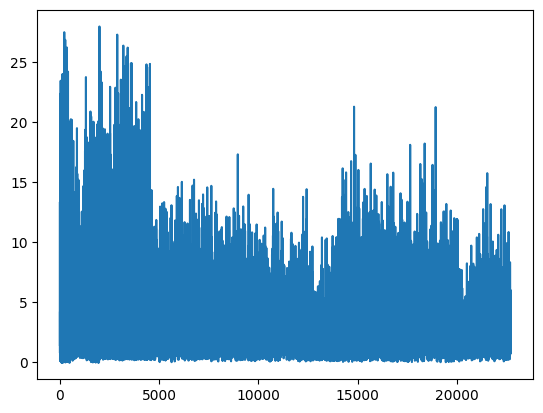

In [108]:
# ??? maximum values is well above 1. Check, if these values should be normalized.
plt.plot(match_scores.cpu().numpy())
plt.show()

# layer swapping

In [109]:
def _swap_activs(model1, model1_layers, model2_activations, idx, model1_statistics):
    def edit_rule(data, model):
        data[:,idx, :, :] = ((model2_activations[:,idx,:,:].float()*model1_statistics[1][:,idx,:,:])+ model1_statistics[0][:,idx,:,:]).float()
        return data
    
    standalone_model.edit_layer(model1_layers, edit_rule)

In [110]:
def find_act(act_num, net_dict):
    layers_list = list(net_dict)
    
    layer = 0
    counter = 0
    
    while act_num >= counter:
        layer +=1
        counter += net_dict[layers_list[layer-1]]
        
    act = act_num-counter+net_dict[layers_list[layer-1]]
    
    del layers_list
    torch.cuda.empty_cache()
    return (layer-1), act
        

In [111]:
def resize_and_stack(current_layer, table, model1_activations, model2_activations, all_model2_layers, idxs, k):
    scores = match_scores[idxs]
    map_size = model1_activations.shape[2]
    clip_activ_matches = torch.zeros_like(model1_activations)
    for i,idx in enumerate(idxs):
        clip_act_name = find_act(idx, all_model2_layers)
        activ = model2_activations[clip_act_name[0]][:,clip_act_name[1],:,:].unsqueeze(0)
        activ = torch.nn.functional.interpolate(activ, size = (map_size,map_size), mode = "bicubic")
        clip_activ_matches[:,i,:,:] = activ
        
    scores = torch.einsum('aixy,aixy->ai', model1_activations,clip_activ_matches)/(map_size**2)
    k = clip_activ_matches.shape[1]

    print("Layer" + str(current_layer)+": Replacing Bottom "+str(k)+" out of "+ str(clip_activ_matches.shape[1])+" units")
        
    vals, idxs = torch.topk(-1*scores,k=k)
    
    return (clip_activ_matches,idxs)

In [112]:
def store_activs(model, layers):
    activs = []
    for layer in layers:
        activation = model.retained_layer(layer, clear = True)
        activs.append(activation)
        
    return activs

In [113]:
def dict_layers(activs):
    all_layers = {}
    for iii, activ in enumerate(activs):
        all_layers[activs[iii]] = activ.shape[1]
    return all_layers

In [114]:
def resize_and_stack(curr_layer, table, model1_activations, model2_activations, all_model2_layers, idxs, k):
    scores = match_scores[idxs]
    map_size = model1_activations.shape[2]
    model2_activation_matches = torch.zeros_like(model1_activations)
    for i,idx in enumerate(idxs):
        clip_act_name = find_act(idx, all_model2_layers)
        activ = model2_activations[clip_act_name[0]][:,clip_act_name[1],:,:].unsqueeze(0)
        activ = torch.nn.functional.interpolate(activ, size = (map_size,map_size), mode = "bicubic")
        model2_activation_matches[:,i,:,:] = activ
        
    scores = torch.einsum('aixy,aixy->ai', model1_activations,model2_activation_matches)/(map_size**2)
    k = model2_activation_matches.shape[1]
    print("Layer" + str(curr_layer)+": Replacing Bottom "+str(k)+" out of "+ str(model2_activation_matches.shape[1])+" units")
        
    vals, idxs = torch.topk(-1*scores,k=k)
    
    return (model2_activation_matches,idxs)

In [147]:
def get_deltas(table, imgs, model1, model2, model1_statistics, model2_statistics, model1_layers, model2_layers, match_list):
    deltas = []
    
    # inference model 1
    _ = model1(imgs)

    # preprocess images
    transform = transforms.ToPILImage()
    images_new = []
    for img in imgs:
        images_new.append(clip_preprocess(transform(img)))

    # building image features
    images = torch.tensor(np.stack(images_new)).cuda()
    
    # inference model 2
    _ = model2.model.encode_image(images)
    
    # store layers and activations
    model1_activations = store_activs(model1, model1_layers)
    model2_activations =  store_activs(model2, model2_layers)
    all_model2_layers = dict_layers(model2_activations)
        
    #normalize all activations
    eps = 0.00001
    
    for i,_ in enumerate(model1_activations):
        model1_activations[i] = (model1_activations[i]-model1_statistics[i][0])/(model1_statistics[i][1]+eps)
        
    for i,_ in enumerate(model2_activations):
        model2_activations[i] = (model2_activations[i]-model2_statistics[i][0])/(model2_statistics[i][1]+eps)

    fig=plt.figure(figsize=(20, 20))
    plt.axis("off")
    j = 0 # j keeps track of activation
    for i,_ in enumerate(model1_activations):
        match_idxs = match_list[j:j+model1_activations[i].shape[1]]
        j+=model1_activations[i].shape[1]
        clip_swaps,idxs = resize_and_stack(i, table, model1_activations[i], model2_activations, all_model2_layers, match_idxs, k = 0)
        # before swap
        _ = model1(imgs)
        
        _swap_activs(model1,model1_layers[i],clip_swaps,idxs, model1_statistics[i] )
        # after swap
        _ = model1(imgs)
        after = model1.retained_layer(model1_layers[i], clear = True)
        
        before = model1_activations[i]
        after = clip_swaps
        
        batch_size = before.shape[0]
        channels = before.shape[1]
        map_size = before.shape[2]
        
        scores = torch.einsum('aixy,aixy->', before,after)/(batch_size*map_size**2*channels)
        deltas.append(scores.cpu())
    
    return deltas

In [148]:
# random image
new_batch = next(iter(train_loader))
img = new_batch[0][int(np.random.rand() * new_batch[0].shape[0])]
img.shape

torch.Size([3, 28, 28])

Layer0: Replacing Bottom 64 out of 64 units
Layer1: Replacing Bottom 64 out of 64 units
Layer2: Replacing Bottom 64 out of 64 units
Layer3: Replacing Bottom 256 out of 256 units
Layer4: Replacing Bottom 64 out of 64 units
Layer5: Replacing Bottom 64 out of 64 units
Layer6: Replacing Bottom 256 out of 256 units
Layer7: Replacing Bottom 64 out of 64 units
Layer8: Replacing Bottom 64 out of 64 units
Layer9: Replacing Bottom 256 out of 256 units
Layer10: Replacing Bottom 128 out of 128 units
Layer11: Replacing Bottom 128 out of 128 units
Layer12: Replacing Bottom 512 out of 512 units
Layer13: Replacing Bottom 128 out of 128 units
Layer14: Replacing Bottom 128 out of 128 units
Layer15: Replacing Bottom 512 out of 512 units
Layer16: Replacing Bottom 128 out of 128 units
Layer17: Replacing Bottom 128 out of 128 units
Layer18: Replacing Bottom 512 out of 512 units
Layer19: Replacing Bottom 128 out of 128 units
Layer20: Replacing Bottom 128 out of 128 units
Layer21: Replacing Bottom 512 out of 

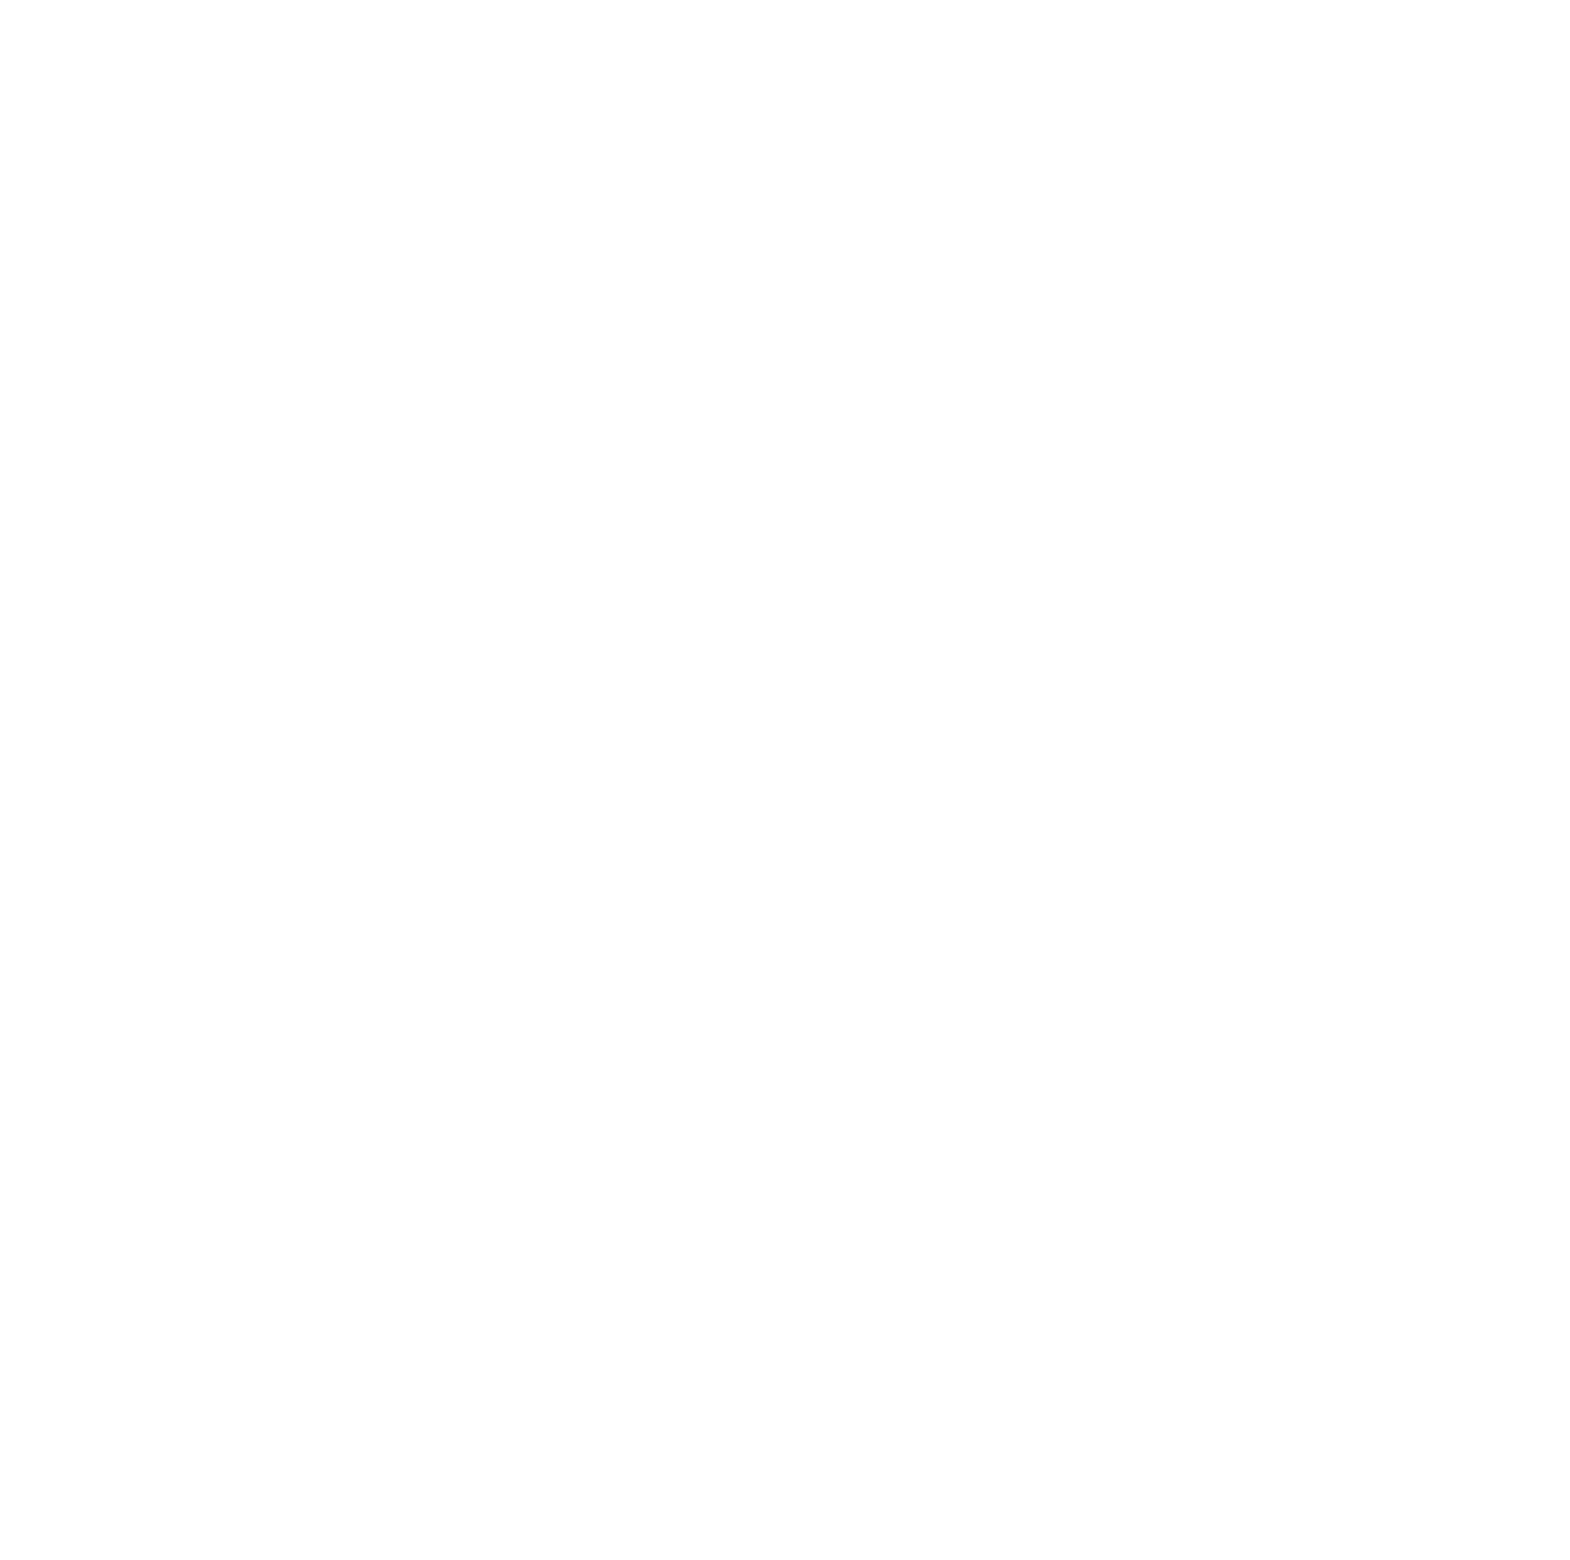

In [149]:
deltas = get_deltas(table, img.to(device).unsqueeze(0), standalone_model, clip_model, model1_statistics, model2_statistics, standalone_layers, clip_layers, clip_idxs)

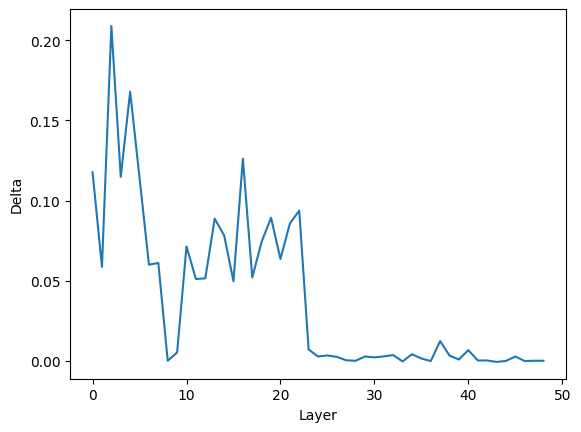

In [152]:
plt.plot(deltas)
plt.xlabel("Layer")
plt.ylabel("Delta")
plt.show()